In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pscan import pscan_view, organize_pscans

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
mpiout_path = '/srv/cluster/mini_gillespiem/.simulators/keep/run.pkl'
with open(mpiout_path, 'rb') as f:
    n_processing = 1
    locations, data = pickle.loads(f.read())
    pspace, pscans = organize_pscans(locations, data, n_processing)

In [8]:
pscans[0]

,Batch,Event Count,Events,Mean Event Duration,Mean Event Height,Parameters,StdDev Event Height,Target,Toxic Probability,eta_p,kappa_I,phi
0,"[[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...",NaN,[],NaN,NaN,None,NaN,time,NaN,0.00,1.000000e-07,1.0
1,"[[0.0, 1.0, 1.0, 21.0, 21.0, 1.0, 1.0, 0.0, 19...",1192.0,"[[(1069, 1126), (1141, 1157), (1165, 1289), (1...",63.002517,21.062466,"{'high': 19.825, 'low': 4.575, 'min_dt': 5, 'e...",12.840932,T_free,0.834276,0.00,1.000000e-07,1.0
2,"[[0.0, 88.0, 95.0, 130.0, 113.0, 105.0, 131.0,...",20.0,"[[], [(1458, 8893)], [(1757, 9680)], [(1724, 4...",2892.250000,170.202874,"{'high': 194.350325, 'low': 44.850075, 'min_dt...",85.635743,I,0.740966,0.00,1.000000e-07,1.0
3,"[[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...",NaN,[],NaN,NaN,None,NaN,time,NaN,0.00,1.000000e-07,10.0
4,"[[0.0, 19.0, 1.0, 2.0, 16.0, 0.0, 31.0, 0.0, 1...",1188.0,"[[(1054, 1061), (1122, 1128), (1214, 1228), (1...",26.720539,14.778503,"{'high': 18.85, 'low': 4.35, 'min_dt': 5, 'eff...",12.581570,T_free,0.353167,0.00,1.000000e-07,10.0
5,"[[0.0, 67.0, 69.0, 79.0, 98.0, 261.0, 293.0, 3...",0.0,"[[], [], [], [], [], [], [], [], [], []]",-1.000000,-1.000000,"{'high': 208.65, 'low': 48.15, 'min_dt': 5, 'e...",-1.000000,I,0.000000,0.00,1.000000e-07,10.0
6,"[[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...",NaN,[],NaN,NaN,None,NaN,time,NaN,0.00,1.000000e-07,100.0
7,"[[0.0, 20.0, 9.0, 0.0, 5.0, 0.0, 0.0, 28.0, 0....",72.0,"[[(3127, 3133), (3369, 3375), (4585, 4591), (4...",11.277778,12.964048,"{'high': 17.875, 'low': 4.125, 'min_dt': 5, 'e...",11.291325,T_free,0.010384,0.00,1.000000e-07,100.0
8,"[[0.0, 66.0, 69.0, 261.0, 259.0, 182.0, 161.0,...",0.0,"[[], [], [], [], [], [], [], [], [], []]",-1.000000,-1.000000,"{'high': 209.625325, 'low': 48.375075, 'min_dt...",-1.000000,I,0.000000,0.00,1.000000e-07,100.0
9,"[[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...",NaN,[],NaN,NaN,None,NaN,time,NaN,0.05,1.000000e-07,1.0


In [11]:
pscan = pscans[0]
subspace = {
    #'kappa_T': 0.0000001, 
    #'kappa_T': 0, 
    'kappa_I': 0.1, 
    #'kappa_M': 0.5, 
    #'lambda_i': 20, 
    'phi': 10.0, 
}
targets = ('time', 'T_free', 'I')

selection = pscan_view(pscan, subspace, targets)
selection.shape, selection.columns

trajectory = 0
target = 'T_free'

time_selection = selection.loc[selection['Target'] == 'time'].reset_index()
target_selection = selection.loc[selection['Target'] == target].reset_index()

n_fig = target_selection.shape[0]
f, axes = plt.subplots(n_fig, 1, figsize=(12, 2 * n_fig))
f.subplots_adjust(wspace=0.8, hspace=0.8)
for (t, time), (l, location), ax in zip(time_selection.iterrows(), target_selection.iterrows(), axes):
    subspace = location[pspace.columns]
    subspace = ', '.join(('%s: %s' % (i, j)) for i, j in zip(subspace.index, subspace.values))
    ax.set_title('location: %s' % subspace)
    counts = location['Batch'][trajectory, :]
    time = time['Batch'][trajectory, :]
    ax.plot(time, counts, linewidth=3)
    events = location['Events']
    if events and sum([len(e) for e in events]):
        parameters = location['Parameters']
        high, low = parameters['high'], parameters['low']
        medium = (high + low) / 2.0
        ax.plot([time[0] - 1, time[-1] + 1], [low, low], color='k', ls='--')
        ax.plot([time[0] - 1, time[-1] + 1], [medium, medium], color='k', ls='--')
        ax.plot([time[0] - 1, time[-1] + 1], [high, high], color='k', ls='--')
        for i, j in events[trajectory]:
            ax.plot([time[i], time[j]], [medium, medium], color='r', lw=5, marker='s')
    ax.set_xlim((0.2 * time.shape[0], min(0.2 * time.shape[0] + 1000, time[-1])))

IndexError: index out of range

TypeError: Empty 'DataFrame': no numeric data to plot

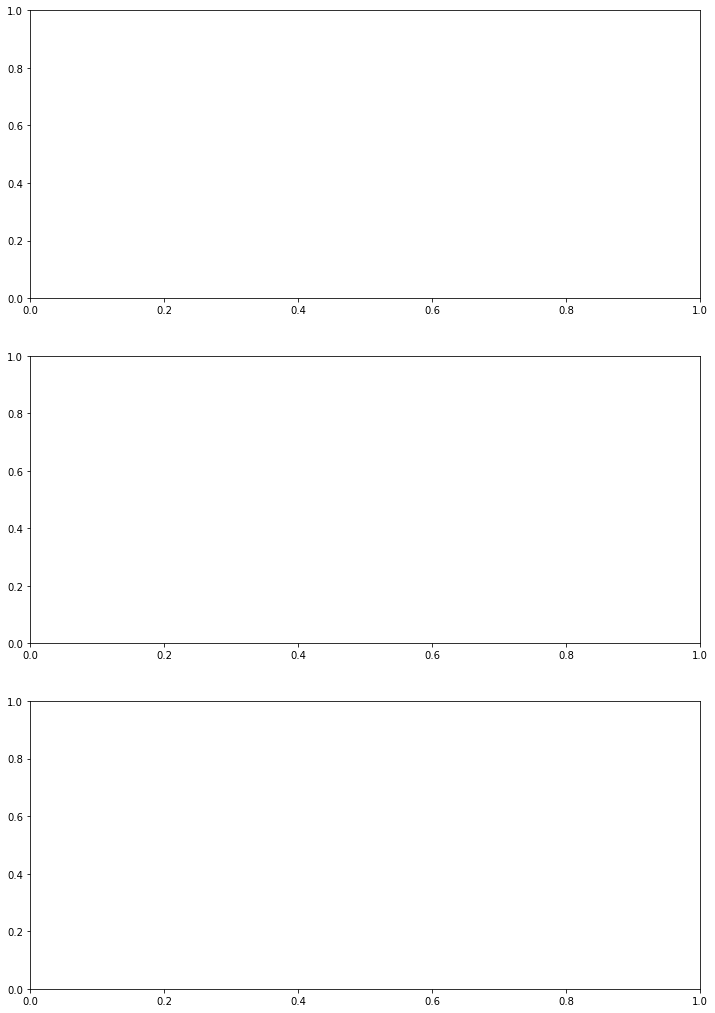

In [12]:
pscan = pscans[0]
subspace = {
    #'kappa_T': 0.0000001, 
    #'kappa_T': 0, 
    'kappa_I': 0.1, 
    #'kappa_M': 1.0, 
    #'lambda_i': 5, 
    'phi': 100.0, 
}
targets = ('time', 'T_free', 'I')

selection = pscan_view(pscan, subspace, targets)
selection.shape, selection.columns

trajectory = 0
target = 'T_free'

time_selection = selection.loc[selection['Target'] == 'time'].reset_index()
target_selection = selection.loc[selection['Target'] == target].reset_index()

x = 'eta_p'
ys = [['Toxic Probability'], ['Mean Event Duration'], ['Event Count']]

#print(target_selection[x])

n = len(ys)
f, axes = plt.subplots(n, 1, figsize=(12, n * 6))
for ax, targets in zip(axes, ys):
    target_selection.plot(x=x, y=targets, ax=ax)
    ax.set_title('%s Versus %s' % (', '.join(targets), x))
    ax.set_xlabel(x)
    ax.set_ylabel(', '.join(targets))

(420,) (420,) (420,)
(20,) (21,) (420,)
(420, 420) (420, 420)
(20, 21)


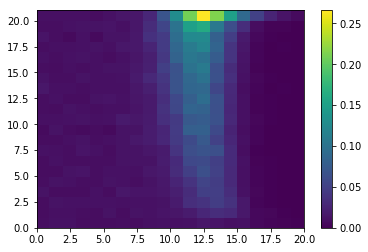

In [15]:
pscan = pscans[0]
subspace = {
    #'kappa_T': 0.0000001, 
    #'kappa_T': 0, 
    #'kappa_I': 0.1, 
    'phi': 100.0, 
    #'sigma_i': 20, 
}
targets = ('time', 'T_free', 'I')
target = 'T_free'

selection = pscan_view(pscan, subspace, targets)
selection = selection.loc[selection['Target'] == target].reset_index()
selection.shape, selection.columns

x = selection['kappa_I'].values
#x = selection['phi'].values
y = selection['eta_p'].values
z = selection['Toxic Probability'].values
print(x.shape, y.shape, z.shape)
print(np.unique(x).shape, np.unique(y).shape, z.shape)

X, Y = np.meshgrid(x, y)
print(X.shape, Y.shape)
print(z.reshape(np.unique(x).shape[0], np.unique(y).shape[0]).shape)
plt.pcolor(z.reshape(np.unique(x).shape[0], np.unique(y).shape[0]).transpose())
plt.colorbar()

In [19]:
selection[['phi', 'eta_p', 'Toxic Probability']]

,phi,eta_p,Toxic Probability
0,100.0,0.00,0.010384
1,100.0,0.05,0.008732
2,100.0,0.10,0.009160
3,100.0,0.15,0.013495
4,100.0,0.20,0.009974
5,100.0,0.25,0.008416
6,100.0,0.30,0.009313
7,100.0,0.35,0.012142
8,100.0,0.40,0.008979
9,100.0,0.45,0.007917
